In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [27]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [28]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


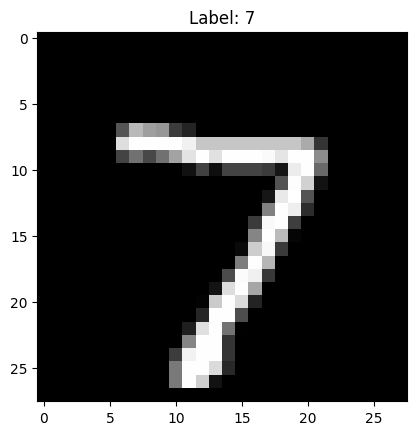

In [29]:
import matplotlib.pyplot as plt
def show_image(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()
show_image(X[0], y[0])

In [30]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [31]:
import torch.nn.functional as F
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        # input: 28 * 28
        # after first conv with kernel size 5: 24 * 24
        # after first pool: 12 * 12
        # after second conv with kernel size 5: 8 * 8
        # after second pool: 4 * 4
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = NeuralNetwork().to(device)
print(model)
X = X.to(device)
x = X[0].to(device)
model(X)

NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


tensor([[ 5.8863e-02, -1.0314e-01,  8.2143e-02, -1.7942e-02,  8.6686e-02,
         -5.9447e-02, -8.2187e-03,  5.6793e-03, -4.6130e-02,  1.9320e-02],
        [ 6.1856e-02, -8.2125e-02,  8.1672e-02, -1.2610e-02,  8.2788e-02,
         -5.7773e-02, -8.1496e-03,  2.9086e-02, -4.4689e-02,  3.6231e-02],
        [ 6.5731e-02, -1.0123e-01,  7.9953e-02, -2.3280e-02,  8.0531e-02,
         -5.1576e-02, -2.0550e-02,  1.2715e-02, -5.0640e-02,  1.9248e-02],
        [ 6.3566e-02, -1.0159e-01,  8.6879e-02, -1.7991e-02,  8.1387e-02,
         -5.5076e-02, -5.9179e-03,  2.3423e-02, -4.6447e-02,  2.4943e-02],
        [ 6.6535e-02, -1.0185e-01,  8.3070e-02, -1.7202e-02,  7.7287e-02,
         -6.2211e-02, -4.5690e-03,  1.4121e-02, -4.7804e-02,  2.6989e-02],
        [ 6.5003e-02, -1.0309e-01,  7.6233e-02, -2.5040e-02,  7.9330e-02,
         -5.1669e-02, -2.2497e-02,  8.5425e-03, -5.3132e-02,  2.5035e-02],
        [ 6.6501e-02, -1.0494e-01,  7.3791e-02, -2.1337e-02,  8.2009e-02,
         -5.8077e-02, -5.6123e-0

In [32]:
import numpy as np
total_params = 0
for params in model.parameters():
    current_layer_size = np.prod(params.shape)
    print("Current layer size: ", current_layer_size)
    total_params += current_layer_size
total_params

Current layer size:  150
Current layer size:  6
Current layer size:  2400
Current layer size:  16
Current layer size:  30720
Current layer size:  120
Current layer size:  10080
Current layer size:  84
Current layer size:  840
Current layer size:  10


44426

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
import time
start = time.time()
epochs = 5
test(test_dataloader, model, loss_fn)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done in ", time.time() - start, " seconds")

Test Error: 
 Accuracy: 9.1%, Avg loss: 2.305011 

Epoch 1
-------------------------------
loss: 2.303705  [   64/60000]
loss: 2.311559  [ 6464/60000]
loss: 2.305902  [12864/60000]
loss: 2.299397  [19264/60000]
loss: 2.290324  [25664/60000]
loss: 2.305754  [32064/60000]
loss: 2.310317  [38464/60000]
loss: 2.308900  [44864/60000]
loss: 2.301286  [51264/60000]
loss: 2.296918  [57664/60000]
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.300978 

Epoch 2
-------------------------------
loss: 2.299212  [   64/60000]
loss: 2.306777  [ 6464/60000]
loss: 2.302367  [12864/60000]
loss: 2.295259  [19264/60000]
loss: 2.288781  [25664/60000]
loss: 2.302387  [32064/60000]
loss: 2.305556  [38464/60000]
loss: 2.305829  [44864/60000]
loss: 2.297535  [51264/60000]
loss: 2.293281  [57664/60000]
Test Error: 
 Accuracy: 15.5%, Avg loss: 2.296882 

Epoch 3
-------------------------------
loss: 2.294836  [   64/60000]
loss: 2.301764  [ 6464/60000]
loss: 2.298210  [12864/60000]
loss: 2.291070  [19264/60000]
loss:

In [37]:
import time
start = time.time()
epochs = 95
test(test_dataloader, model, loss_fn)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done in ", time.time() - start, " seconds")

Test Error: 
 Accuracy: 30.1%, Avg loss: 2.273697 

Epoch 1
-------------------------------
loss: 2.271137  [   64/60000]
loss: 2.276597  [ 6464/60000]
loss: 2.272983  [12864/60000]
loss: 2.263204  [19264/60000]
loss: 2.257730  [25664/60000]
loss: 2.269225  [32064/60000]
loss: 2.270618  [38464/60000]
loss: 2.270711  [44864/60000]
loss: 2.254058  [51264/60000]
loss: 2.255198  [57664/60000]
Test Error: 
 Accuracy: 43.6%, Avg loss: 2.251399 

Epoch 2
-------------------------------
loss: 2.249337  [   64/60000]
loss: 2.252872  [ 6464/60000]
loss: 2.247308  [12864/60000]
loss: 2.233288  [19264/60000]
loss: 2.224857  [25664/60000]
loss: 2.235671  [32064/60000]
loss: 2.239175  [38464/60000]
loss: 2.234028  [44864/60000]
loss: 2.206384  [51264/60000]
loss: 2.213970  [57664/60000]
Test Error: 
 Accuracy: 51.0%, Avg loss: 2.199036 

Epoch 3
-------------------------------
loss: 2.198809  [   64/60000]
loss: 2.196806  [ 6464/60000]
loss: 2.182954  [12864/60000]
loss: 2.157520  [19264/60000]
loss